# Import thư viện.

In [45]:
from pyspark.sql import * 
from pyspark.sql.functions import *

# Khởi tạo Spark Session.

In [46]:
spark = SparkSession.builder \
    .appName("Analysis") \
    .getOrCreate()

# Đọc file dữ liệu và tổng quan.

In [47]:
df = spark.read.csv('./data/preprocessed_data.csv', header=True, inferSchema=True, quote='"' , escape ='"', multiLine=True)

In [48]:
df.show()

+---+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+--------+-------+--------+-------------+--------------------+
|_c0|   video_id|trending_date|               title|       channel_title|    category_id|       publish_time|                tags|   views|  likes|dislikes|comment_count|         description|
+---+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+--------+-------+--------+-------------+--------------------+
|  0|Jw1Y-zhQURU|   2017-11-14|John Lewis Christ...|          John Lewis|  Howto & Style|2017-11-10 07:38:29|"christmas|""john...| 7224515|  55681|   10247|         9479|Click here to con...|
|  1|3s1rvMFUweQ|   2017-11-14|Taylor Swift: …Re...| Saturday Night Live|  Entertainment|2017-11-12 06:24:44|"SNL|""Saturday N...| 1053632|  25561|    2294|         2757|Musical guest Tay...|
|  2|n1WpP7iowLc|   2017-11-14|Eminem - 

### Sắp xếp dữ liệu theo số views tăng dần.

In [49]:
df = df.orderBy('views', asc=False)

In [50]:
df.show()

+----+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+-----+-----+--------+-------------+--------------------+
| _c0|   video_id|trending_date|               title|       channel_title|    category_id|       publish_time|                tags|views|likes|dislikes|comment_count|         description|
+----+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+-----+-----+--------+-------------+--------------------+
|3477|n26wtR-OFr8|   2017-12-01|Mountain Bikers W...|    That's Surrey TV|News & Politics|2017-11-27 18:08:49|"Surrey|""That's ...|  851|   12|       0|            3|A group of mounta...|
|3701|n26wtR-OFr8|   2017-12-02|Mountain Bikers W...|    That's Surrey TV|News & Politics|2017-11-27 18:08:49|"Surrey|""That's ...|  890|   13|       0|            3|A group of mounta...|
|3908|n26wtR-OFr8|   2017-12-03|Mountain Bikers W...|    Tha

### Lấy số views cao nhất của mỗi video.

In [51]:
windowSpec = Window.partitionBy("title").orderBy(col("views").desc())
windowSpec

In [52]:
view_df = df.withColumn("view_rank", row_number().over(windowSpec))
view_df.show()

+-----+-----------+-------------+--------------------+-----------------+--------------+-------------------+--------------------+------+-----+--------+-------------+--------------------+---------+
|  _c0|   video_id|trending_date|               title|    channel_title|   category_id|       publish_time|                tags| views|likes|dislikes|comment_count|         description|view_rank|
+-----+-----------+-------------+--------------------+-----------------+--------------+-------------------+--------------------+------+-----+--------+-------------+--------------------+---------+
|  567|NLCfRHdi6Ig|   2017-11-16|#21 How to go FAS...|       Ben Cathro|        Sports|2017-11-05 20:10:16|"Ben Cathro|""sic...| 16074|  689|       8|          142|How flipping rad ...|        1|
|  358|NLCfRHdi6Ig|   2017-11-15|#21 How to go FAS...|       Ben Cathro|        Sports|2017-11-05 20:10:16|"Ben Cathro|""sic...| 15818|  686|       8|          141|How flipping rad ...|        2|
|  146|NLCfRHdi6Ig| 

In [53]:
view_df = view_df.filter(col('view_rank') == 1)
view_df = view_df.drop(view_df.view_rank)

In [54]:
view_df.show()

+-----+-----------+-------------+-----------------------+--------------------+----------------+-------------------+--------------------+--------+------+--------+-------------+--------------------+
|  _c0|   video_id|trending_date|                  title|       channel_title|     category_id|       publish_time|                tags|   views| likes|dislikes|comment_count|         description|
+-----+-----------+-------------+-----------------------+--------------------+----------------+-------------------+--------------------+--------+------+--------+-------------+--------------------+
|  567|NLCfRHdi6Ig|   2017-11-16|   #21 How to go FAS...|          Ben Cathro|          Sports|2017-11-05 20:10:16|"Ben Cathro|""sic...|   16074|   689|       8|          142|How flipping rad ...|
| 1791|1cgK-BIrXes|   2017-11-22|   #VeteransDay: Tha...|   YouTube Spotlight|   Entertainment|2017-11-10 15:07:13|"vets|""veterans ...|  916104| 27405|    2153|         5292|This #VeteransDay...|
|  701|d6YkGejS

In [55]:
view_df.select(sum('views')).show()

+-----------+
| sum(views)|
+-----------+
|15915944060|
+-----------+



# Phân tích.

## Video có nhiều tương tác nhất.

In [ ]:
# Tương tác bằng tổng số likes + dislikes + comments.
view_df = view_df.withColumn('total_reactions', col('likes')+col('dislikes')+col('comment_count'))
highest_interaction = view_df.groupBy('title').agg(max('total_reactions').alias('total_reactions'))
highest_interaction = highest_interaction.orderBy(col("total_reactions").desc())

In [57]:
highest_interaction.show()

+-------------------------+---------------+
|                    title|total_reactions|
+-------------------------+---------------+
|BTS (방탄소년단) 'FAKE...|        7049374|
|     Childish Gambino ...|        6377774|
|     YouTube Rewind: T...|        5911375|
|       Drake - God’s Plan|        5156827|
|                So Sorry.|        5143583|
|     Bad Bunny - Amorf...|        4264625|
|     Ariana Grande - N...|        3804136|
|BTS (방탄소년단) 'MIC ...|        3574348|
|     j-hope 'Daydream ...|        3178754|
|     Marvel Studios' A...|        3126405|
|BTS (방탄소년단) LOVE ...|        3102006|
|     Nicky Jam x J. Ba...|        3067426|
|     Luis Fonsi, Demi ...|        2968324|
|     Maroon 5 - Girls ...|        2876711|
|     Te Bote Remix - C...|        2862074|
|     Ed Sheeran - Perf...|        2747840|
|BTS (방탄소년단) 'Euph...|        2505493|
|     Bruno Mars - Fine...|        2492881|
|     Taylor Swift - De...|        2470323|
|     Taylor Swift - En...|        2441133|
+-------

#### Plot biểu đồ.

In [58]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 48177 (\N{HANGUL SYLLABLE B

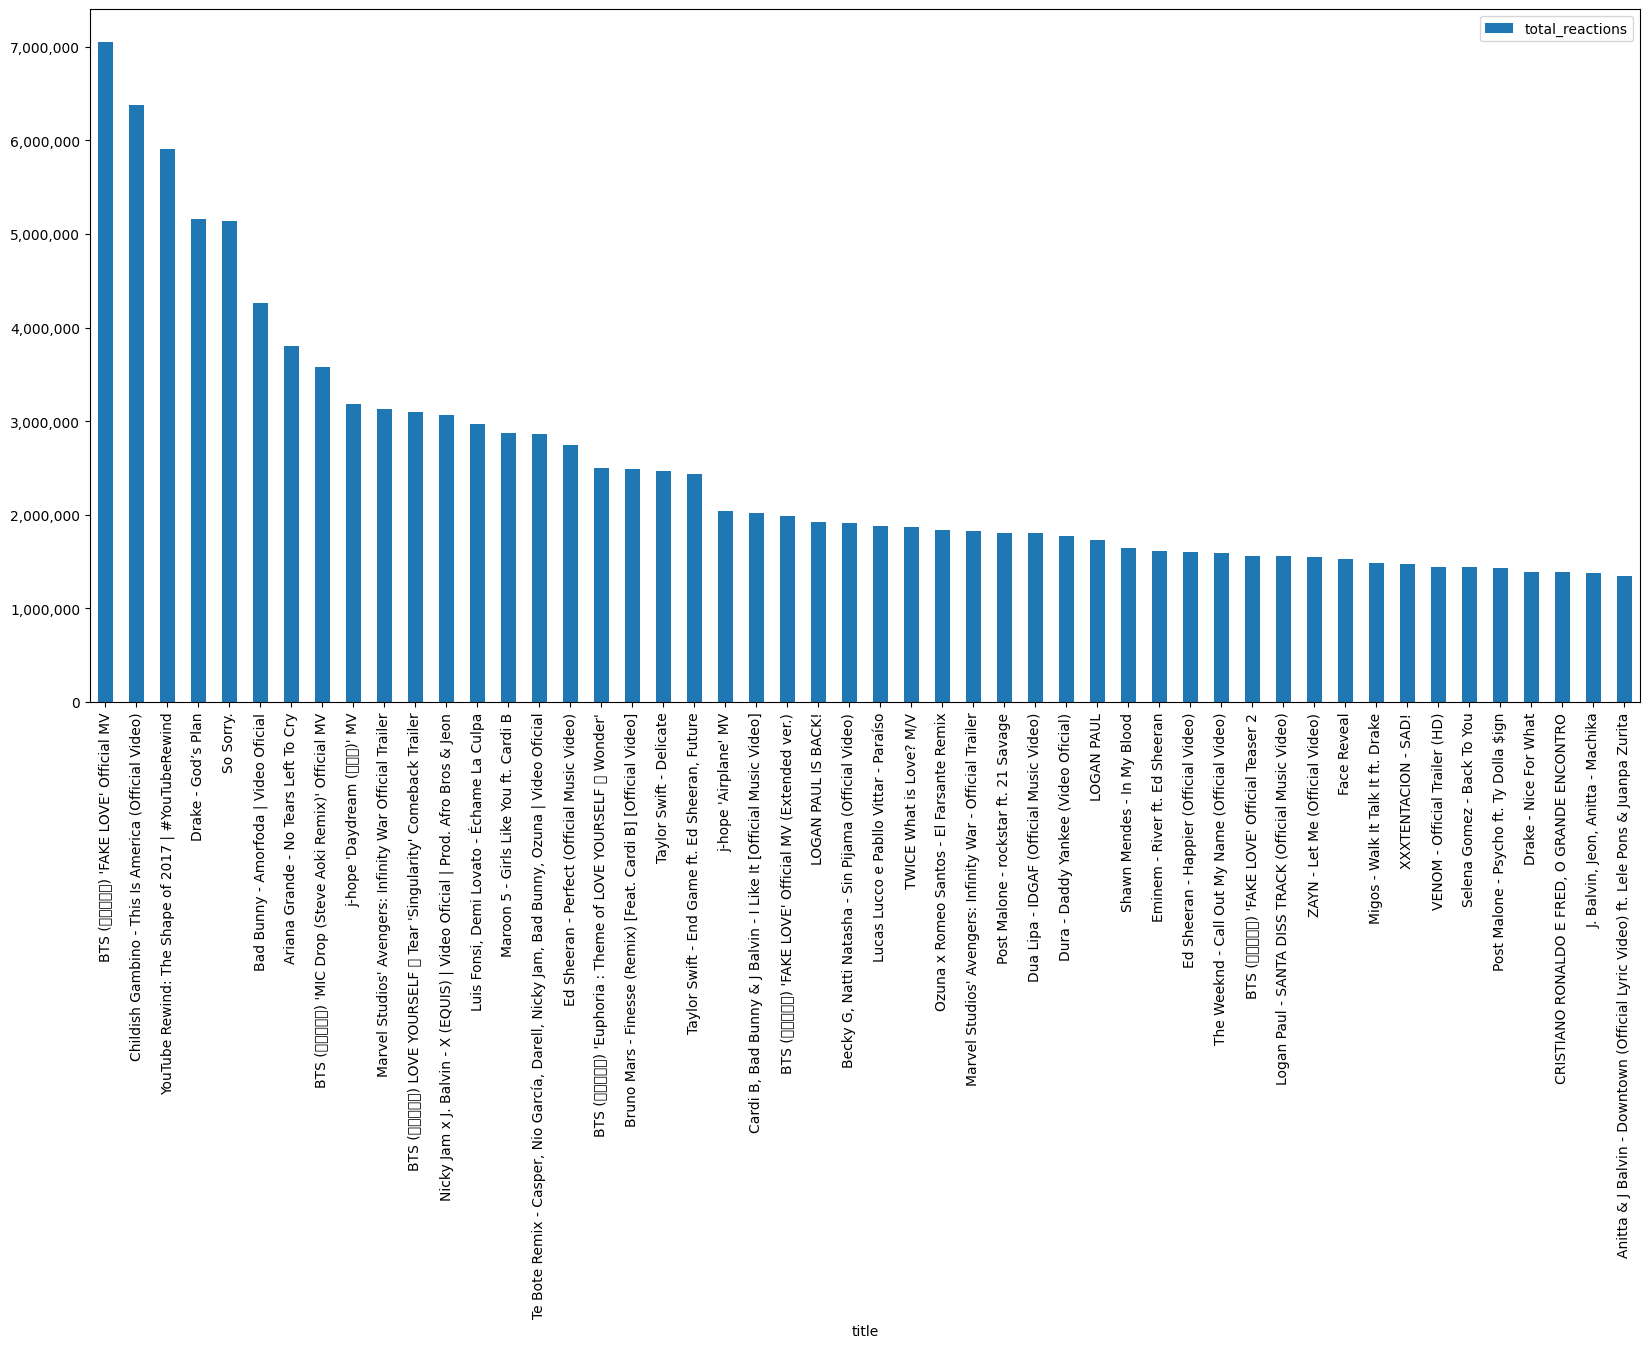

In [90]:
interaction_df = highest_interaction.limit(50).toPandas() # Đoạn sau giá trị giảm chậm, không chênh nhiều.
ax = interaction_df.plot.bar(x = 'title', y='total_reactions', figsize = (20,9))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')) 

## Videos có nhiều lượt likes nhất.

In [68]:
highest_like = view_df.groupBy('title').agg(max('likes').alias('likes'))
highest_like = highest_like.orderBy(col("likes").desc())

In [69]:
highest_like.show()

+-------------------------+-------+
|                    title|  likes|
+-------------------------+-------+
|BTS (방탄소년단) 'FAKE...|5613827|
|     Childish Gambino ...|5444541|
|       Drake - God’s Plan|4737873|
|     Bad Bunny - Amorf...|3823879|
|     Ariana Grande - N...|3394437|
|     YouTube Rewind: T...|3312868|
|BTS (방탄소년단) 'MIC ...|2960250|
|     Nicky Jam x J. Ba...|2818771|
|     Marvel Studios' A...|2701353|
|BTS (방탄소년단) LOVE ...|2700801|
|     Luis Fonsi, Demi ...|2686169|
|     Maroon 5 - Girls ...|2677256|
|     j-hope 'Daydream ...|2672433|
|     Ed Sheeran - Perf...|2584773|
|     Te Bote Remix - C...|2581961|
|BTS (방탄소년단) 'Euph...|2250087|
|     Bruno Mars - Fine...|2248693|
|     Taylor Swift - De...|2161260|
|     Taylor Swift - En...|2153475|
|     j-hope 'Airplane' MV|1841936|
+-------------------------+-------+
only showing top 20 rows



#### Plot biểu đồ.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 36681 (\N{CJK UNIFIED IDEOG

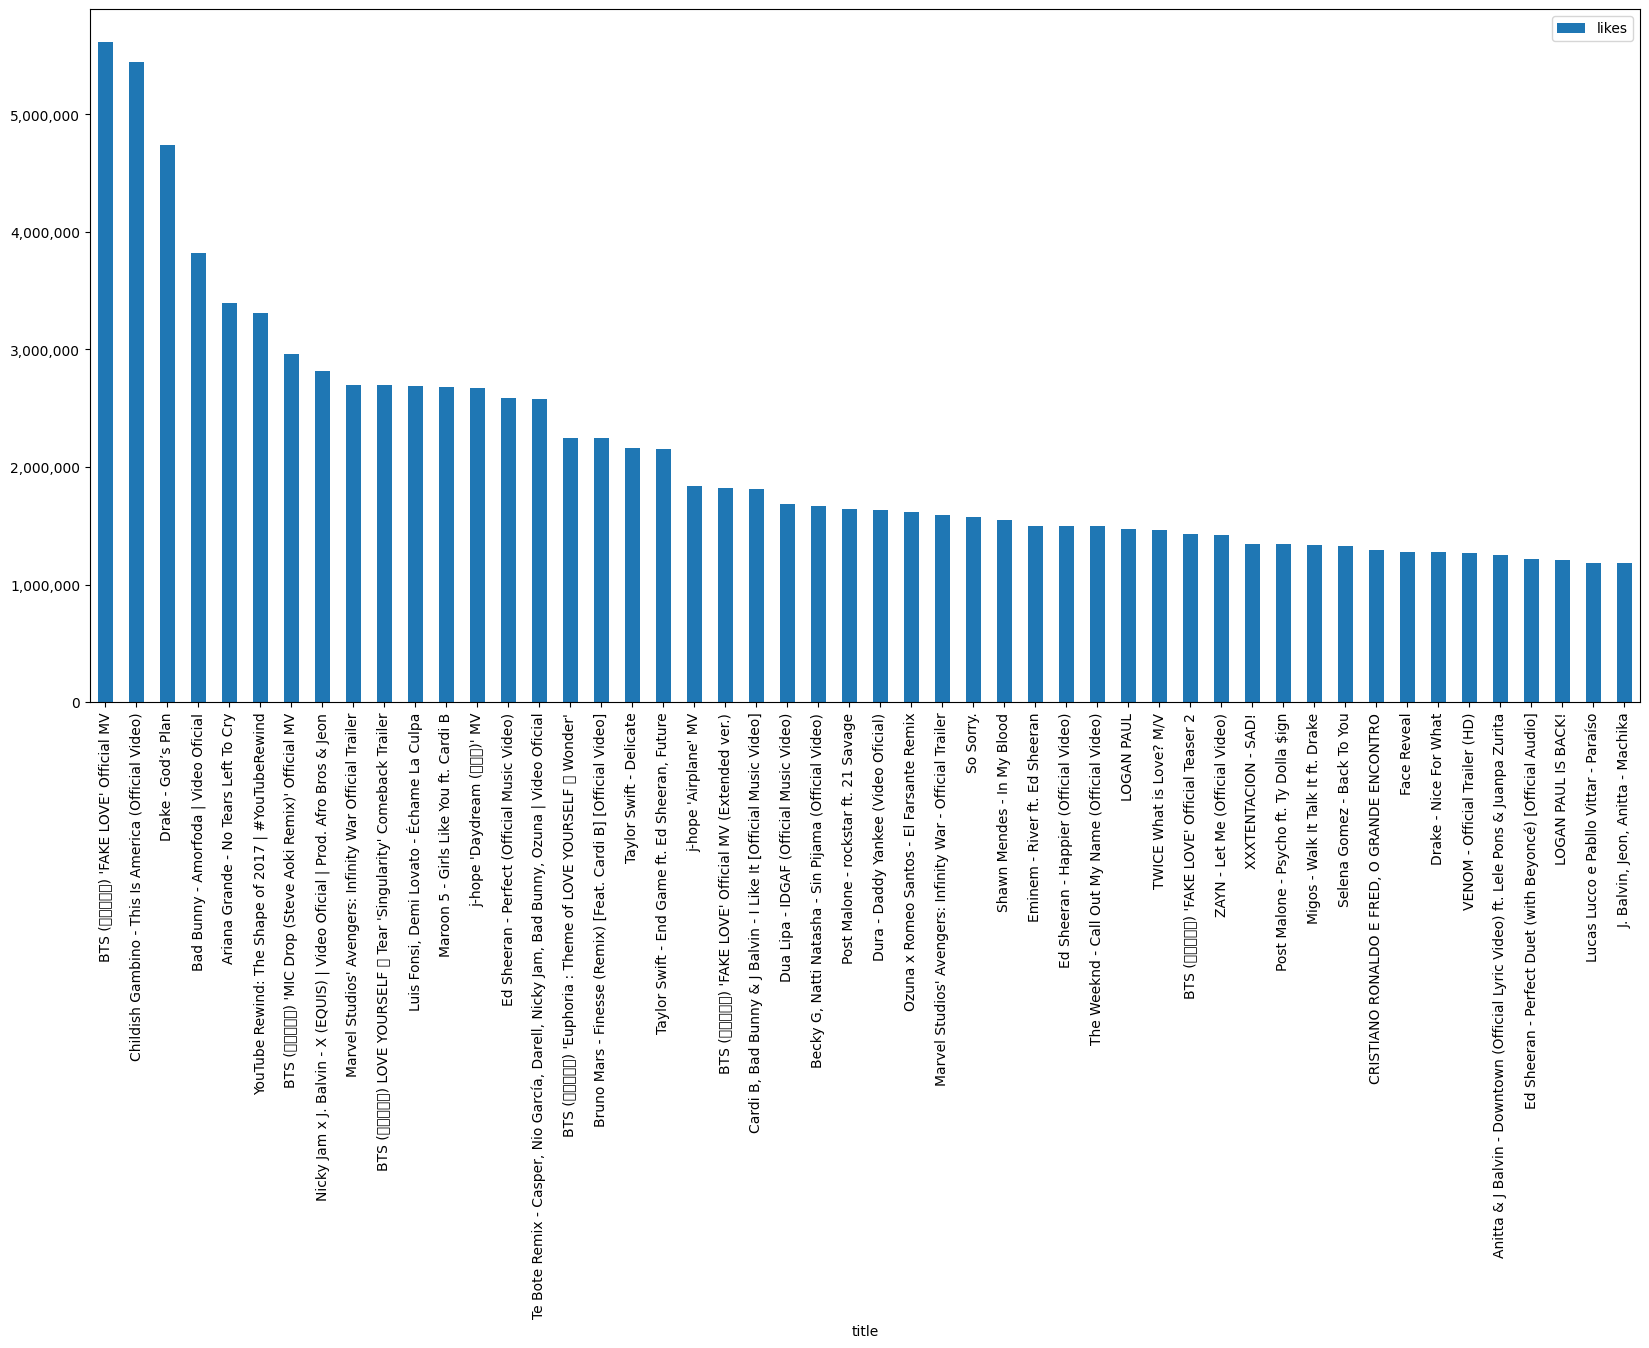

In [89]:
pandas_total_like_df = highest_like.limit(50).toPandas()
ay = pandas_total_like_df.plot.bar(x = 'title', y='likes', figsize = (20,9))
ay.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')) 

## Videos có nhiều lượt dislikes nhất.

In [82]:
highest_dislike = view_df.groupBy('title').agg(max('dislikes').alias('dislikes'))
highest_dislike = highest_dislike.orderBy(col("dislikes").desc())

In [83]:
highest_dislike.show()

+-------------------------+--------+
|                    title|dislikes|
+-------------------------+--------+
|                So Sorry.| 1944971|
|     YouTube Rewind: T...| 1753274|
|     Lucas Lucco e Pab...|  421473|
|     Childish Gambino ...|  379862|
|      LOGAN PAUL IS BACK!|  280675|
|     PSA from Chairman...|  258504|
|     Bad Bunny - Amorf...|  215530|
|BTS (방탄소년단) 'FAKE...|  206892|
|     Fergie Performs T...|  193053|
|     Katy Perry - Hey ...|  171027|
|     Logan Paul - SANT...|  167640|
|     Te Bote Remix - C...|  166549|
|     Shakira - Trap (O...|  155954|
|     Ozuna x Romeo San...|  151147|
|     Ariana Grande - N...|  150086|
|     Nicky Jam x J. Ba...|  149275|
|     Jason Derulo, Mal...|  149024|
|     Becky G, Natti Na...|  142569|
|     Luis Fonsi, Demi ...|  137938|
|     Taylor Swift - De...|  133428|
+-------------------------+--------+
only showing top 20 rows



#### Plot biểu đồ.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 10060 (\N{CROSS MARK}) miss

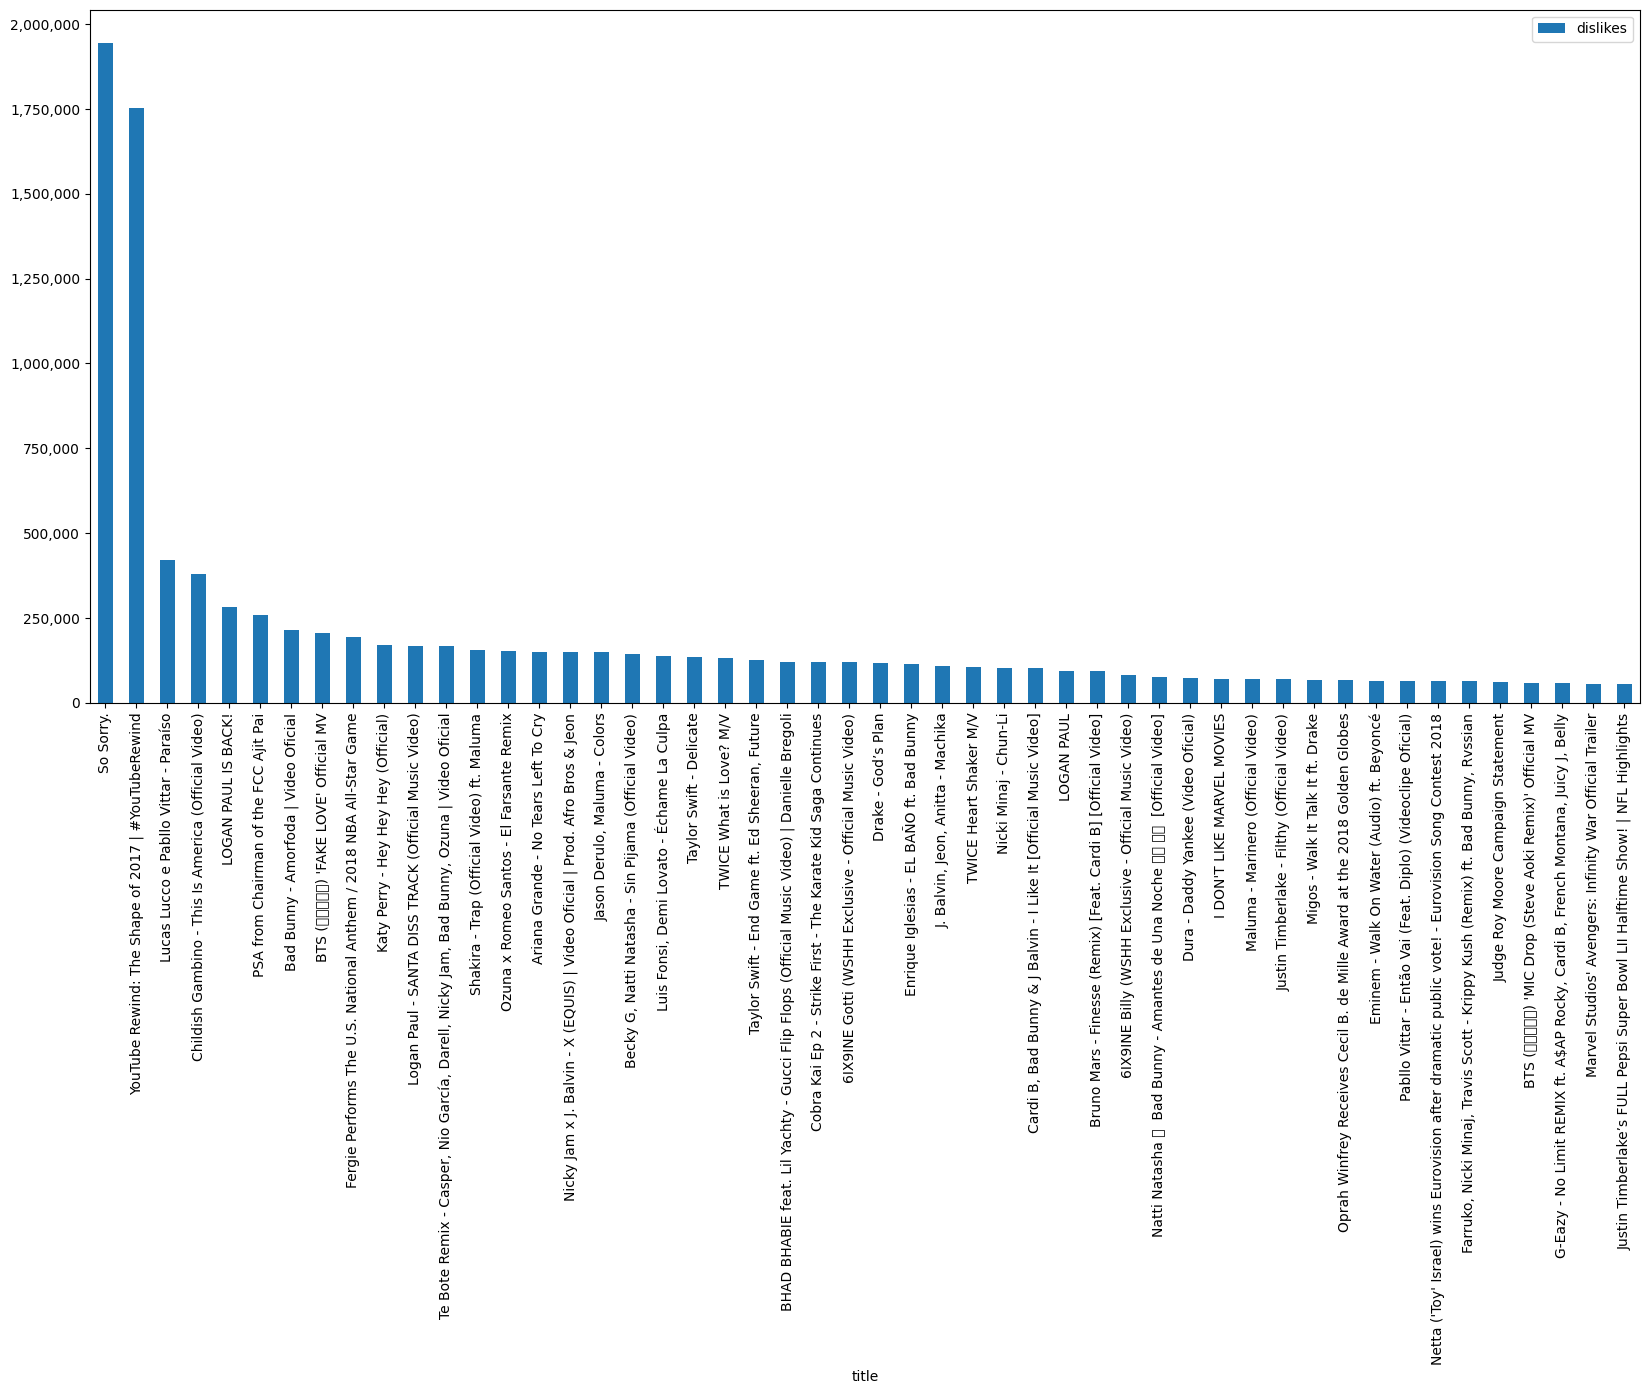

In [91]:
pandas_total_dl_df = highest_dislike.limit(50).toPandas()
az = pandas_total_dl_df.plot.bar(x = 'title', y='dislikes', figsize = (20,9))
az.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')) 

## Videos có nhiều comments nhất.

In [ ]:
highest_cmt = view_df.groupBy('title').agg(max('comment_count').alias('comment_count'))
highest_cmt = highest_cmt.orderBy(col("comment_count").desc())

In [94]:
highest_cmt.show()

+-------------------------+-------------+
|                    title|comment_count|
+-------------------------+-------------+
|                So Sorry.|      1626501|
|BTS (방탄소년단) 'FAKE...|      1228655|
|     YouTube Rewind: T...|       845233|
|BTS (방탄소년단) 'MIC ...|       556154|
|     Childish Gambino ...|       553371|
|     j-hope 'Daydream ...|       477233|
|      LOGAN PAUL IS BACK!|       432534|
|BTS (방탄소년단) LOVE ...|       371864|
|     Marvel Studios' A...|       368739|
|       Drake - God’s Plan|       301756|
|     Lucas Lucco e Pab...|       275795|
|     TWICE What is Lov...|       274087|
|     Ariana Grande - N...|       259613|
|BTS (방탄소년단) 'Euph...|       234455|
|            GOT7 Look M/V|       234054|
|              Face Reveal|       225618|
|     Bad Bunny - Amorf...|       225216|
|     Logan Paul - SANT...|       212787|
|     Regarding the rum...|       205692|
|     Marvel Studios' A...|       199294|
+-------------------------+-------------+
only showing

#### Plot biểu đồ.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 48177 (\N{HANGUL SYLLABLE B

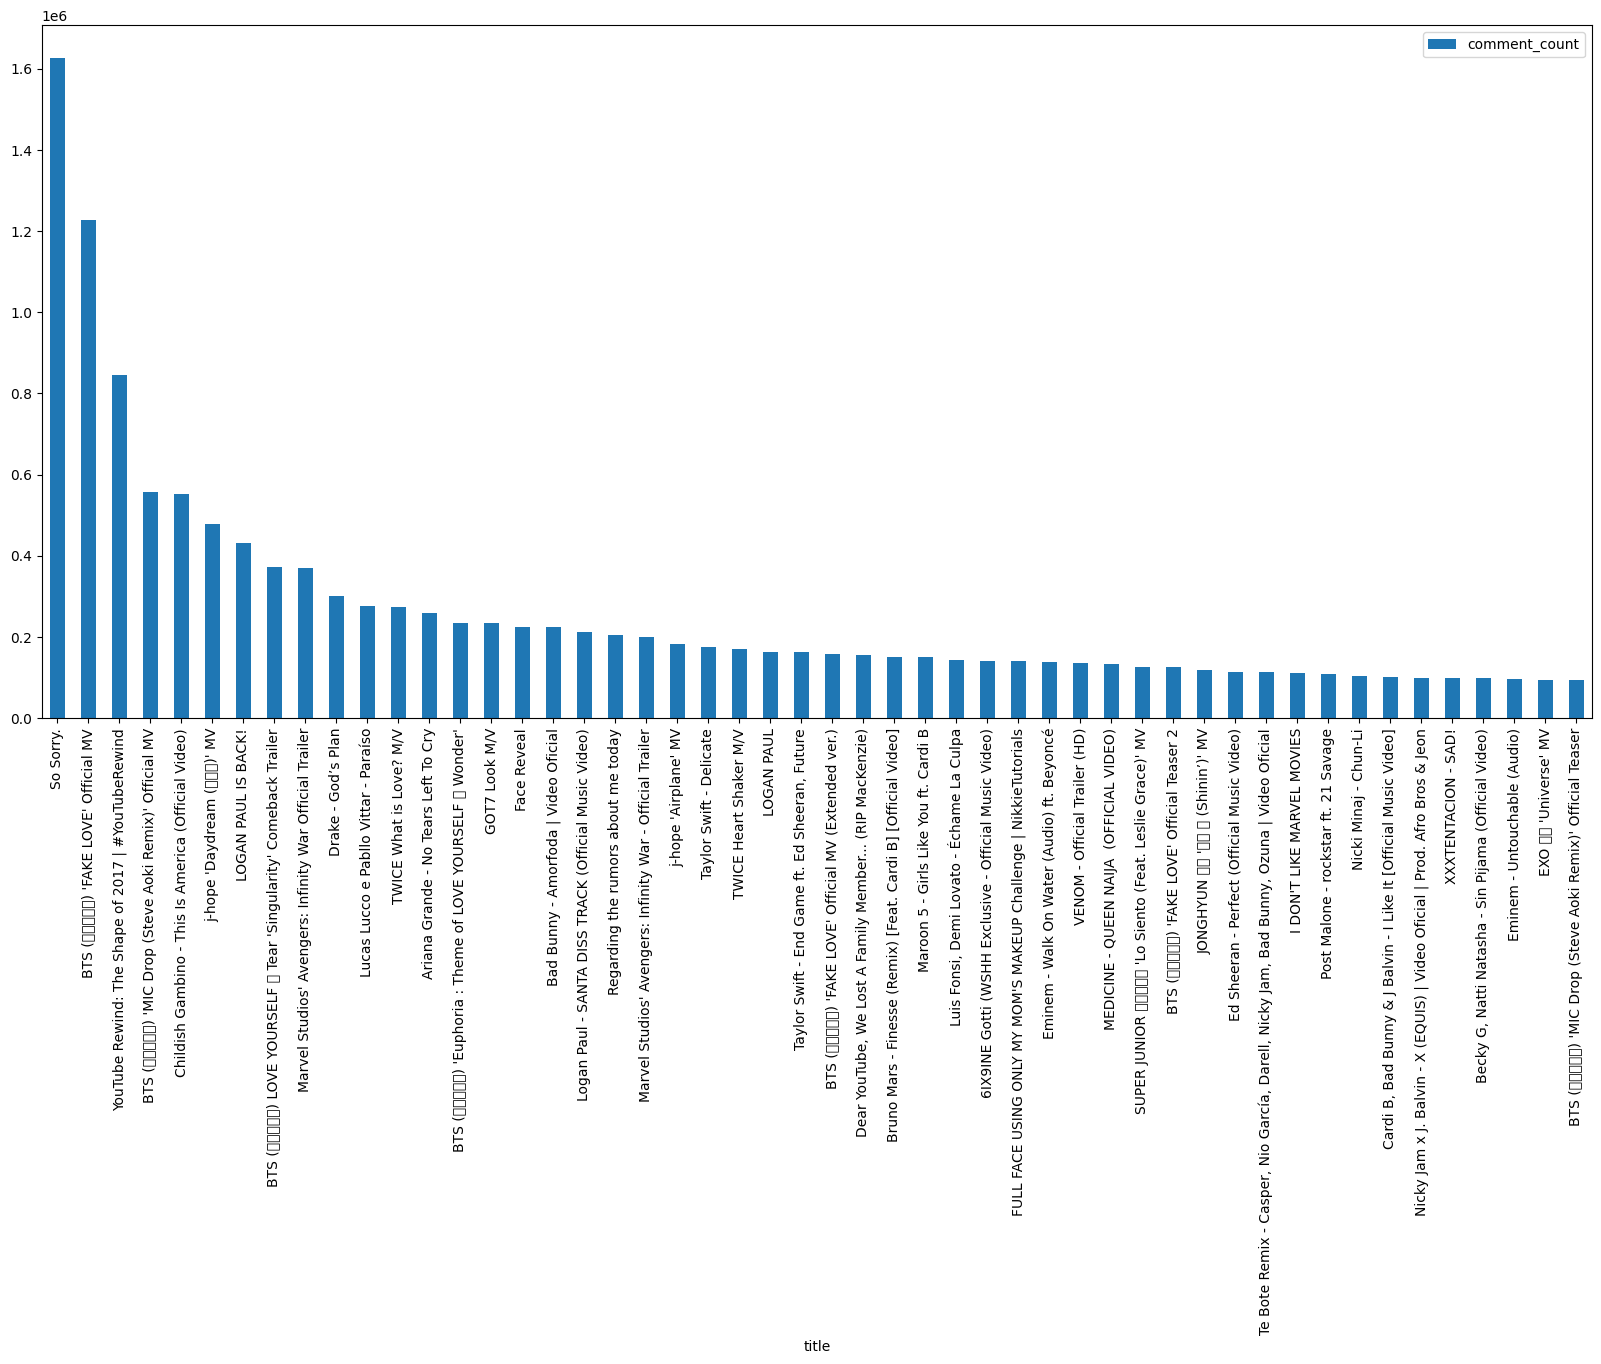

In [97]:
pandas_total_cmt_df = highest_cmt.limit(50).toPandas()
pandas_total_cmt_df.plot.bar(x = 'title', y='comment_count', figsize = (20, 9))
az.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}')) 